### Resources

**Load Images**
- https://huggingface.co/docs/datasets/use_with_pytorch
- https://huggingface.co/docs/datasets/v2.14.5/en/image_load

**Process images:**
- image processing: https://huggingface.co/docs/datasets/image_process#map
- transforms methods: https://pytorch.org/vision/stable/transforms.html#transforms
- HF general processing: https://huggingface.co/docs/datasets/process
- transforms v2 reference: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

**Test/Train split**
- use this: https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.train_test_split

**PyTorch Classification Tutorial**
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

**Building a Model Basics**
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datasets 
from datasets import Features, Image, load_dataset, load_dataset_builder, config, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

import shutil
import pathlib
import PIL
from PIL import Image

import torch
import torchvision
from torchvision.transforms import v2, ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

Matplotlib created a temporary cache directory at /tmp/matplotlib-rapmyjei because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# get data (from https://huggingface.co/datasets/YakupAkdin/instrument-images/tree/main)
dataset = load_dataset("YakupAkdin/instrument-images", split='train').with_format("torch")

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
# define our labels
label_values = {
    0: 'harp',
    1: 'baglama',
    2: 'electric guitar',
    3: 'acoustic guitar',
    4: 'kanun',
    5: 'violin',
    6: 'kemence',
    7: 'mandolin',
    8: 'oud',
    9: 'yayli tambur'}

inverted_labels = {v: k for k, v in label_values.items()}

In [4]:
# create a pandas copy for easier PIL exploration
df_clone = dataset.to_pandas()
df_clone = df_clone.assign(
    desc = df_clone.label.map(label_values),
    image = df_clone.image.apply(lambda x: x['path']))
df_clone.head()

,image,label,desc
0,/workspace/hf_cache/downloads/c1788b27609c6ad9...,0,harp
1,/workspace/hf_cache/downloads/8f8cdb21c6698ee6...,0,harp
2,/workspace/hf_cache/downloads/41f7f4b3f28c4ede...,0,harp
3,/workspace/hf_cache/downloads/4bce77de0a7870be...,0,harp
4,/workspace/hf_cache/downloads/e5502c68bcbbc862...,0,harp


0 : harp


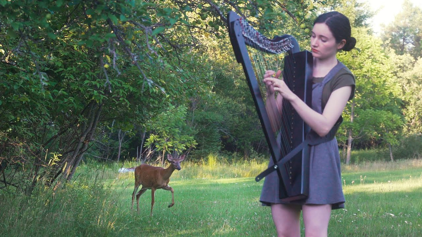

3 : acoustic guitar


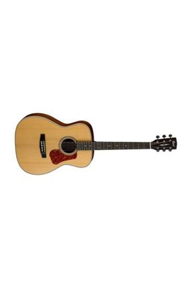

9 : yayli tambur


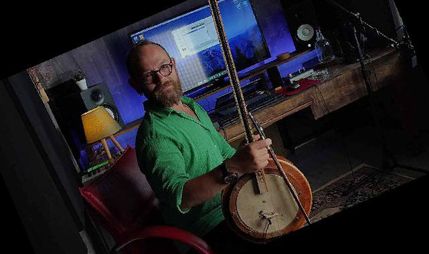

In [5]:
# view the first image and label
def img_check(i, scale):
    print(df_clone.label[i],':',df_clone.desc[i])
    img = PIL.Image.open(df_clone.image[i])
    img = img.resize((int(img.size[0]/(100/scale)), int(img.size[1]/(100/scale))))
    img.show()

img_check(0, 33)
img_check(345, 67)
img_check(999, 67)

In [6]:
# isolate RGB images for pre processing
dataset_RGB = dataset.filter(lambda x: x['image'].dim() == 3)
len(dataset_RGB)

989

In [7]:
# the RGB images are [H,W,3] and PyTorch needs them as [3,H,W]
# included [:3, :, :] slice to adjust any RGBA images to RGB
print(dataset_RGB[0]['image'].shape)

# permute the tensors
def permute_images(batch):
    # Apply the permute operation to each tensor in the batch
    batch['image'] = [img.permute(2, 0, 1)[:3, :, :] for img in batch['image']]
    return batch

dataset_RGB = dataset_RGB.map(permute_images, batched=True, batch_size=100)

dataset_RGB[0]['image'].shape

torch.Size([720, 1280, 3])


torch.Size([3, 720, 1280])

In [8]:
dataset_greyscale = dataset.filter(lambda x: x['image'].dim() == 2)
len(dataset_greyscale)

11

In [9]:
# some of the images are greyscale, so we convert to RGB as well
print(dataset_greyscale[0]['image'].shape)

def grayscale_to_rgb(item):
    item['image'] = item['image'].unsqueeze(0).repeat(3, 1, 1)
    return item

dataset_greyscale = dataset_greyscale.map(grayscale_to_rgb)
print(dataset_greyscale[0]['image'].shape)

torch.Size([849, 900])
torch.Size([3, 849, 900])


In [10]:
# concatenate both reformatted RGB datasets
dataset = concatenate_datasets([dataset_RGB, dataset_greyscale])

In [11]:
# confirming 0-255 scaling and int dtype of image tensors
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print("Sample values:", sample_image.flatten()[:10])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

Tensor dtype: torch.int64
Sample values: tensor([40, 39, 41, 41, 41, 44, 48, 53, 54, 52])
Max value: 255
Min value: 0


In [12]:
# compose transformation function
def scale_tensor(tensor):
    return tensor.float() / 255

basic_transform = v2.Compose([
    scale_tensor, # converts to [0, 1] float dtype
    v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # resize for model requirements
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # required normalization
])

# application function for transforms
def apply_transform(example):
    # Apply the transformation to the 'image' field
    example['image'] = [basic_transform(img) for img in example['image']]
    return example

# apply transforms
dataset = dataset.map(apply_transform, batched=True, batch_size=100)

In [13]:
# quick check on the transform
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print('Sample values:', sample_image.flatten()[0:10])
print('Max value:', sample_image.max().item())
print('Min value:', sample_image.min().item())

Tensor dtype: torch.float32
Sample values: tensor([-1.5316, -1.4965, -1.5577, -1.6685, -1.5304, -1.4278, -1.4253, -1.3859,
        -1.4493, -1.4877])
Max value: 2.4805853366851807
Min value: -1.9362629652023315


### Examine Dataset/Model Compatibility Before Training

In [14]:
# are all tensors shape [3, 224, 224]?

correct_tensor_shape = 0

for i in range(len(dataset)):
    if dataset[i]['image'].shape != torch.Size([3, 224, 224]):
        print(f"Image at index {i} has incorrect shape: {image.shape}")
    else:
        correct_tensor_shape += 1

print(correct_tensor_shape)

1000


2 : electric guitar


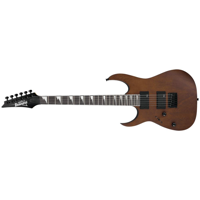

2 : electric guitar


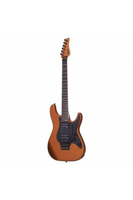

2 : electric guitar


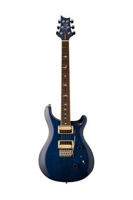

2 : electric guitar


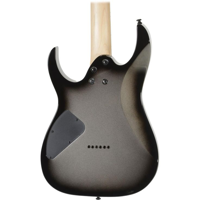

2 : electric guitar


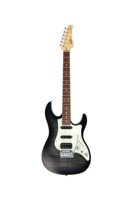

7 : mandolin


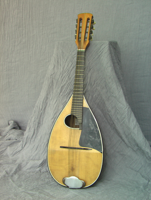

7 : mandolin


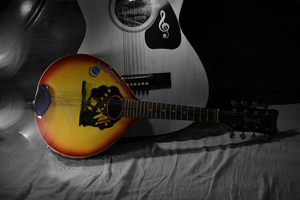

7 : mandolin


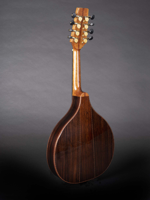

7 : mandolin


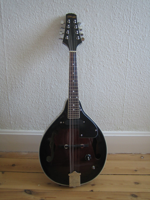

7 : mandolin


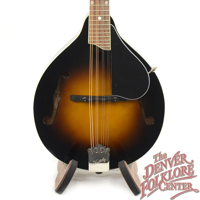

8 : oud


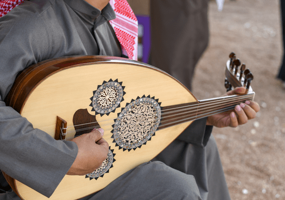

8 : oud


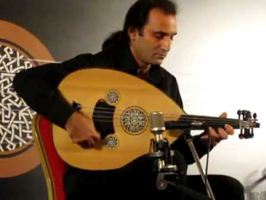

8 : oud


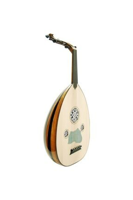

8 : oud


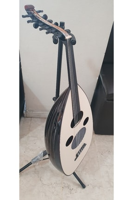

8 : oud


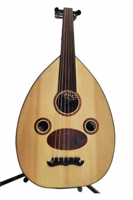

4 : kanun


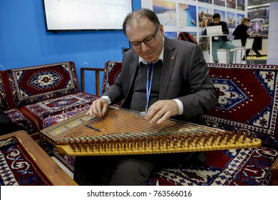

4 : kanun


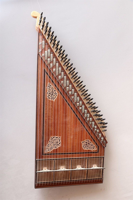

4 : kanun


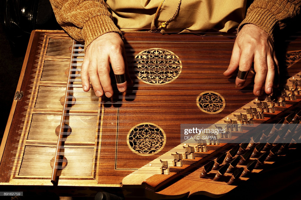

4 : kanun


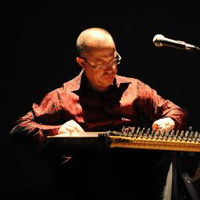

4 : kanun


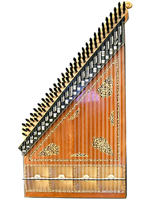

In [15]:
# are labels and images consistent?

#function to print a random x images/labels for a given instrument
def check_instrument(instrument, sample_size):    
    check = df_clone.loc[df_clone.desc == instrument].sample(sample_size).reset_index()
    for row in range(sample_size):
        image = check.image[row]
        img = PIL.Image.open(image).convert('RGB')
        img = img.resize((max(1, int(img.size[0] * 200 / img.size[1])), 200))
        print(check.label[row],':', check.desc[row])
        img.show()        

# check some images
check_instrument('electric guitar', 5)
check_instrument('mandolin', 5)
check_instrument('oud', 5)
check_instrument('kanun', 5)

### Dataloader Setup

In [53]:
# split test/train
dataset = dataset.train_test_split(test_size=0.2, seed=1, stratify_by_column="label")

AttributeError: 'DatasetDict' object has no attribute 'train_test_split'

In [111]:
batch_size = 4

trainloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=2)

In [55]:
# check batch sizing (should be no output)
for batch in trainloader:
    if batch['image'].shape[0] != batch_size:
        print(f"Batch {i} has incorrect batch size: {images.shape[0]}")
    if batch['label'].shape[0] != batch_size:
        print(f"Batch {i} has mismatched images and labels")

In [19]:
# # model from the PyTorch tutorial

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()

**replacing tutorial model with pre-trained [resnet 18](https://arxiv.org/abs/1512.03385)**

In [121]:
# set a cache in our Docker workspace
os.environ['TORCH_HOME'] = os.getcwd()

# import
from torchvision.models import resnet18, ResNet18_Weights

In [122]:
# load model with weights (only one option)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

Using cache found in /workspace/hub/pytorch_vision_v0.10.0


In [123]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [124]:
# modifying the final layer to suit our 10 classes
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# freeze the feature extraction layers
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad=False

### Testing Model before Fine Tuning

In [125]:
# setup:

# create iterator
dataiter = iter(testloader)

# set to eval mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [138]:
# iterate through the test batch (could use training images too, we have not fine tuned to this dataset)
def testbatch():
    batch = next(dataiter)
    images = batch['image']
    labels = batch['label']

# test the model output on these images
    with torch.no_grad():
        outputs = model(images)
    actual = [label_values[lbl.item()] for lbl in labels]
    predicted = [label_values[i.item()] for i in torch.max(outputs, 1)[1]]
    print('predicted: '+', '.join(predicted))
    print('actual: '+', '.join(actual))
    print(' ')

testbatch()
testbatch()
testbatch()

predicted: kemence, yayli tambur, kemence, baglama
actual: oud, kemence, mandolin, oud
 
predicted: mandolin, kemence, kemence, kemence
actual: mandolin, violin, mandolin, violin
 
predicted: acoustic guitar, mandolin, yayli tambur, yayli tambur
actual: kanun, baglama, oud, baglama
 


In [127]:
# calculate accuracy
correct = 0
total = 0

for data in testloader:
    images = data['image']
    labels = data['label']
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'{correct} of {total} images categorized correctly: {100 * correct // total} %')

24 of 200 images categorized correctly: 12 %


**Note: our tutorial model after 25 quick training loops beats this by 28%**

In [128]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for batch in testloader:
    images = batch['image']
    labels = batch['label']
    with torch.no_grad():
        output = model(images)
    _, predicted = torch.max(output, 1)

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

In [129]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

In [130]:
# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

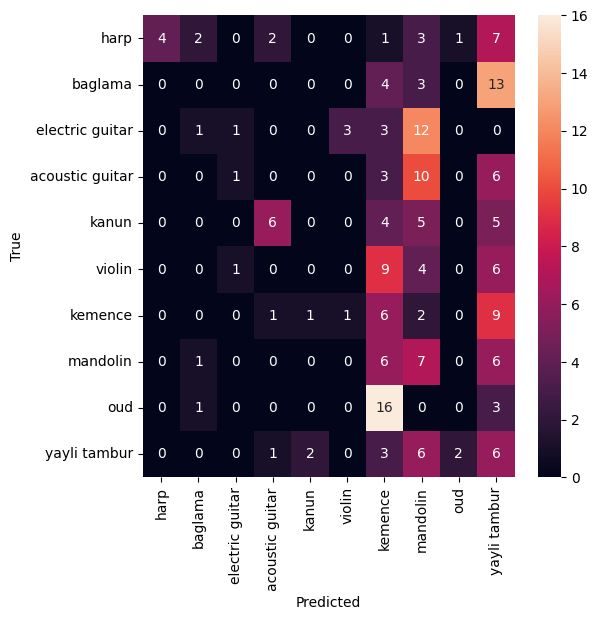

In [131]:
# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### next steps (12/2/2023)
- load/freeze/modify model
- pass one batch through the model to test it
- test accuracy on the test images with no fine-tuning
- connect to GPU (AWS)
- fine tune
- test!

In [30]:
# # Define loss function: Classification Cross-Entropy loss and SGD with momentum.

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [31]:
# for epoch in range(25):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs = data['image']
#         labels = data['label']
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 200 == 199:    # print every 200 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
#             running_loss = 0.0

# print('Finished Training')

### Saving and Testing the Model

In [32]:
# # save the locally-trained model in current working directory
# pwd = os.getcwd()
# filename = 'model v001.pth'
# path = os.path.join(pwd, filename)
# torch.save(net.state_dict(), path)

### Check Model Performance on Test Dataset

In [33]:
# # in case we need to load model later
# pwd = os.getcwd()
# filename = 'model v001.pth'
# path = os.path.join(pwd, filename)
# net.load_state_dict(torch.load(path))

In [34]:
# ## testing a batch of images

# # iterate through the dataset
# dataiter = iter(testloader)
# batch = next(dataiter)
# images = batch['image']
# labels = batch['label']

# # print some test imagery and labels
# imshow(torchvision.utils.make_grid(images))
# actual = [label_values[labels[i].item()] for i in range(4)]
# print('actual: '+', '.join(actual))

# # test the model output on these images
# outputs = net(images)
# predicted = [label_values[i.item()] for i in torch.max(outputs, 1)[1]]
# print('predicted: '+', '.join(predicted))

In [35]:
# compare images from highest and lowest performing instruments (mandolin/oud)
check_instrument(7, dataset['test'])
check_instrument(8, dataset['test'])

TypeError: '<' not supported between instances of 'Dataset' and 'int'

In [ ]:
# # examine images that were predicted correctly and incorrectly
# def add_predictions(example, i):
#     example['predicted_label'] = pred_label[i]
#     return example

# test_results = dataset['test'].map(add_predictions, with_indices=True)

# test_pass = test_results.filter(lambda x: x['label'] == x['predicted_label'])
# test_fail = test_results.filter(lambda x: x['label'] != x['predicted_label'])

In [ ]:
# def check_results(ds, limit):

#     images = ds['image'][0:limit]
#     labels = ds['label'][0:limit]
#     predict = ds['predicted_label'][0:limit]

#     label_list = ''
#     for i, lbl in enumerate(labels):
#         true = label_values[labels[i].item()]
#         pred = label_values[predict[i].item()]
#         print(f'actual: {true} | predicted: {pred}')
#         plt.figure(figsize=(1, 1))
#         imshow(images[i])

In [ ]:
# check_results(test_fail, 20)